In [17]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report

In [2]:
# Custom dataset class for loading images
class ImageDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None):
        self.real_dir = real_dir
        self.fake_dir = fake_dir
        self.transform = transform
        
        # Get image paths for real and fake images
        self.real_images = os.listdir(real_dir)
        self.fake_images = os.listdir(fake_dir)
        
        # Create full paths for the images and assign labels
        self.image_paths = [os.path.join(real_dir, img) for img in self.real_images] + \
                           [os.path.join(fake_dir, img) for img in self.fake_images]
        
        # 0 for real, 1 for fake
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [3]:
from torchvision import transforms

# Enhanced Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizes images to 224x224
    transforms.RandomHorizontalFlip(),  # Flip images horizontally
    transforms.RandomRotation(15),  # Rotate images by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Change brightness, contrast, etc.
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Small affine transformations (rotation, translation, etc.)
    transforms.RandomCrop(224, padding=10),  # Random crop with padding for more variance
    transforms.ToTensor(),  # Converts image to tensor, scales pixel values to [0, 1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats THIS IS KEY HERE AS WE ARE USING A PRETRAINED MODEL
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
from sklearn.model_selection import train_test_split

# Define paths to your real and fake image directories
real_dir = 'final_cleaned_dataset/resized_data/rezised_real'
fake_dir = 'final_cleaned_dataset/resized_data/rezised_fake'

# Create the full dataset
full_dataset = ImageDataset(real_dir, fake_dir, transform=train_transform)

# Split the dataset into training (75%), validation (15%), and testing (15%)
train_indices, test_indices = train_test_split(range(len(full_dataset)), test_size=0.3, random_state=42, stratify=full_dataset.labels)
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=42, stratify=[full_dataset.labels[i] for i in test_indices])

# Create Subsets for train/val/test
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

# DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

# Load the pretrained ViT model for binary classification
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=2, ignore_mismatched_sizes=True)

# Move the model to the GPU if available (MPS for Mac M1)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

### Next 3 Cells used for Training - Do Not Run When Evaluating / Testing

In [6]:
# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer so it can be trained
for param in model.classifier.parameters():
    param.requires_grad = True

In [8]:
def train_model(
    model,            # The PyTorch model to train
    train_loader,     # DataLoader for training data
    val_loader,       # DataLoader for validation data
    device,           # Device (cpu, mps, or cuda)
    num_epochs=10,    # Number of epochs to train for
    lr=1e-4,          # Learning rate
    model_save_path='best_model.pth'  # Path to save the best model
):
    # Define the optimizer and loss function
    optimizer = optim.AdamW(model.classifier.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss for binary classification

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_recall = 0.0  # To track the model with the best recall

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Training loop with tqdm progress bar
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate average loss and accuracy for the epoch
        epoch_train_loss = running_loss / total_samples
        epoch_train_accuracy = correct_predictions / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                val_outputs = model(val_images).logits
                loss = loss_fn(val_outputs, val_labels)

                # Track validation loss and accuracy
                val_loss += loss.item() * val_images.size(0)
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct_predictions += (val_predicted == val_labels).sum().item()
                val_total_samples += val_labels.size(0)

                # Collect labels and predictions for metrics calculation
                all_labels.extend(val_labels.cpu().numpy())
                all_predictions.extend(val_predicted.cpu().numpy())

        # Calculate average validation loss and accuracy
        epoch_val_loss = val_loss / val_total_samples
        epoch_val_accuracy = val_correct_predictions / val_total_samples
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        # Calculate precision, recall, f1, and support using sklearn
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')
        print(f'Val Precision: {precision:.4f}, Val Recall: {recall:.4f}, Val F1-Score: {f1:.4f}')

        # Save the model if it has the best recall
        if recall > best_val_recall:
            best_val_recall = recall
            torch.save(model.state_dict(), model_save_path)
            print(f'Saved best model with validation recall: {best_val_recall:.4f}')

    # Visualize loss and accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Load the best model before returning
    model.load_state_dict(torch.load(model_save_path))
    return model

In [ ]:
trained_model = train_model(model, train_loader, val_loader, device, num_epochs=50, lr=1e-5, model_save_path='best_vit_model.pth')

### Evaluation on Test Set - Run From Here

## Understanding Positive and Negative Classes in Binary Classification

In binary classification, the dataset is divided into two distinct classes, often referred to as the **positive class** and the **negative class**. In the context of deepfake detection:

- **Positive Class (+ve)**: Fake images (deepfakes)
- **Negative Class (-ve)**: Real images

### Confusion Matrix

For a binary classification problem, the performance of the model is often evaluated using a **confusion matrix**. The confusion matrix represents the counts of true and false positives, and true and false negatives, and is structured as follows:

|                  | Predicted: Real (-ve) | Predicted: Fake (+ve) |
|------------------|-----------------------|-----------------------|
| **Actual: Real (-ve)** | True Negative (TN)   | False Positive (FP)   |
| **Actual: Fake (+ve)** | False Negative (FN)   | True Positive (TP)    |

### Key Definitions:
- **True Positive (TP)**: The number of correctly identified fake images (positive class).
- **False Positive (FP)**: The number of real images incorrectly classified as fake (type I error).
- **True Negative (TN)**: The number of correctly identified real images (negative class).
- **False Negative (FN)**: The number of fake images incorrectly classified as real (type II error).

### Precision, Recall, and F1-Score

Using the confusion matrix, we can derive key performance metrics:

#### Precision:
Precision measures the proportion of correctly predicted fake images (positive class) out of all predicted fake images.

$$\text{Precision} = \frac{TP}{TP + FP}$$

Where:
- \(TP\) = True Positives
- \(FP\) = False Positives

#### Recall (Sensitivity, True Positive Rate):
Recall measures the proportion of correctly predicted fake images (positive class) out of all actual fake images. This is crucial for deepfake detection since missing a fake (i.e., false negatives) can have severe consequences.

$$\text{Recall} = \frac{TP}{TP + FN}$$

Where:
- \(FN\) = False Negatives

#### F1-Score:
The F1-Score provides a harmonic mean between precision and recall, giving a balanced view of the model's performance when dealing with class imbalance.

$$F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

The F1-Score becomes particularly important in cases where one class (e.g., fake images) is more important than the other.

### Accuracy
Accuracy is the proportion of correctly predicted instances (both real and fake) out of the total number of instances.

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

However, in the context of deepfake detection, **accuracy** might not be as informative if the dataset is imbalanced, which is why we rely more on **precision, recall, and F1-score**.

### ROC-AUC Score

The **ROC-AUC (Receiver Operating Characteristic - Area Under the Curve)** score provides a comprehensive view of the model’s performance. It plots the trade-off between **True Positive Rate (Recall)** and **False Positive Rate (FPR)**, where:

$$\text{FPR} = \frac{FP}{FP + TN}$$

The **AUC score** quantifies the area under this curve, with a value of **1** indicating a perfect classifier, and **0.5** indicating random guessing.

### Conclusion:
In deepfake detection, the **positive class** is defined as **fake images**, and the **negative class** is defined as **real images**. Metrics like **recall** are particularly important in this context, as it is critical to minimize the number of **false negatives** (i.e., classifying a fake image as real). The confusion matrix, along with precision, recall, and F1-score, provides a detailed understanding of the model's performance in detecting deepfakes.

In [7]:
# Load the saved model
model.load_state_dict(torch.load('best_vit_model.pth'))
model.eval()  #

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [8]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt

In [13]:
# Testing loop to evaluate on the test dataset
all_test_labels = []
all_test_predictions = []
all_test_probabilities = []
test_loss = 0.0
test_correct_predictions = 0
test_total_samples = 0
# Define loss function again for testing
loss_fn = nn.CrossEntropyLoss()


In [28]:
# Define the function to evaluate the model and visualize results
def evaluate_and_visualize_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_correct_predictions = 0
    test_total_samples = 0
    all_test_labels = []
    all_test_predictions = []
    all_test_probabilities = []

    # Define a loss function (assuming CrossEntropyLoss was used during training)
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to compute gradients during testing
        for test_images, test_labels in tqdm(test_loader, desc="Testing the model"):
            test_images, test_labels = test_images.to(device), test_labels.to(device)

            # Forward pass
            test_outputs = model(test_images).logits
            test_probabilities = torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy()  # Probability for class 1 (fake)
            loss = loss_fn(test_outputs, test_labels)

            # Track loss and accuracy
            test_loss += loss.item() * test_images.size(0)
            _, test_predicted = torch.max(test_outputs, 1)
            test_correct_predictions += (test_predicted == test_labels).sum().item()
            test_total_samples += test_labels.size(0)

            # Store labels and predictions for metrics
            all_test_labels.extend(test_labels.cpu().numpy())
            all_test_predictions.extend(test_predicted.cpu().numpy())
            all_test_probabilities.extend(test_probabilities)

    # Calculate overall test loss and accuracy
    test_loss = test_loss / test_total_samples
    test_accuracy = test_correct_predictions / test_total_samples

    # Calculate precision, recall, F1 score, and ROC-AUC score
    precision, recall, f1, _ = precision_recall_fscore_support(all_test_labels, all_test_predictions, average='binary')
    roc_auc = roc_auc_score(all_test_labels, all_test_probabilities)

    # Print metrics
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1-Score: {f1:.4f}')
    print(f'Test ROC-AUC: {roc_auc:.4f}')

    # Confusion matrix
    conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)
    print(f'Confusion Matrix:\n{conf_matrix}')

    # Return metrics for further use
    return {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'conf_matrix': conf_matrix,
        'test_labels': all_test_labels,
        'test_predictions': all_test_predictions,
        'test_probabilities': all_test_probabilities
    }

# Plotting functions
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def plot_roc_curve(test_labels, test_probabilities, roc_auc):
    fpr, tpr, _ = roc_curve(test_labels, test_probabilities)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for reference
    plt.title('ROC-AUC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

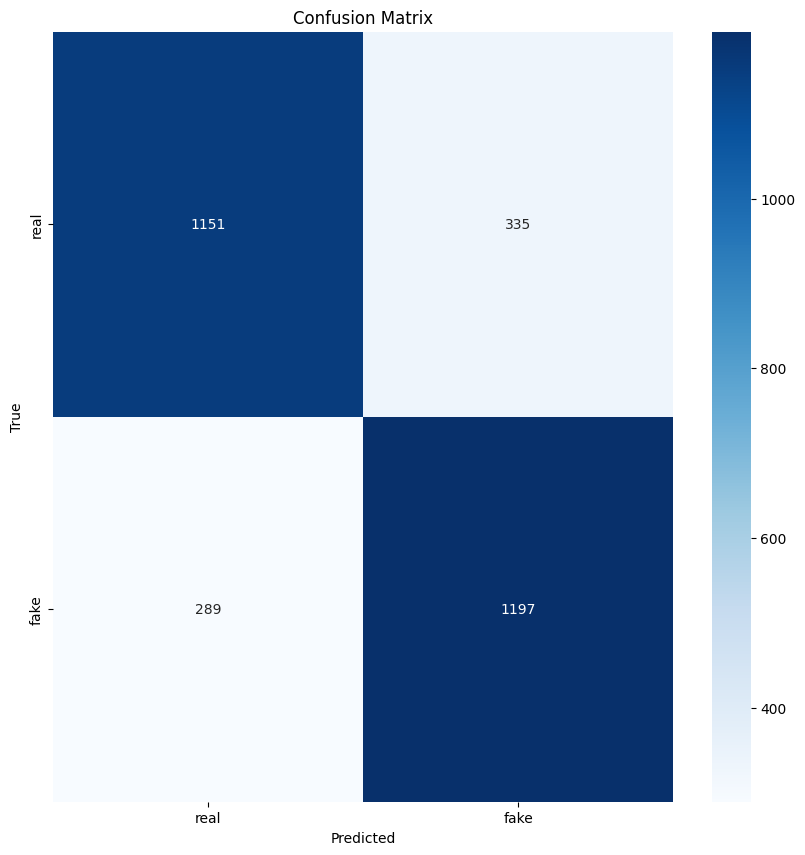

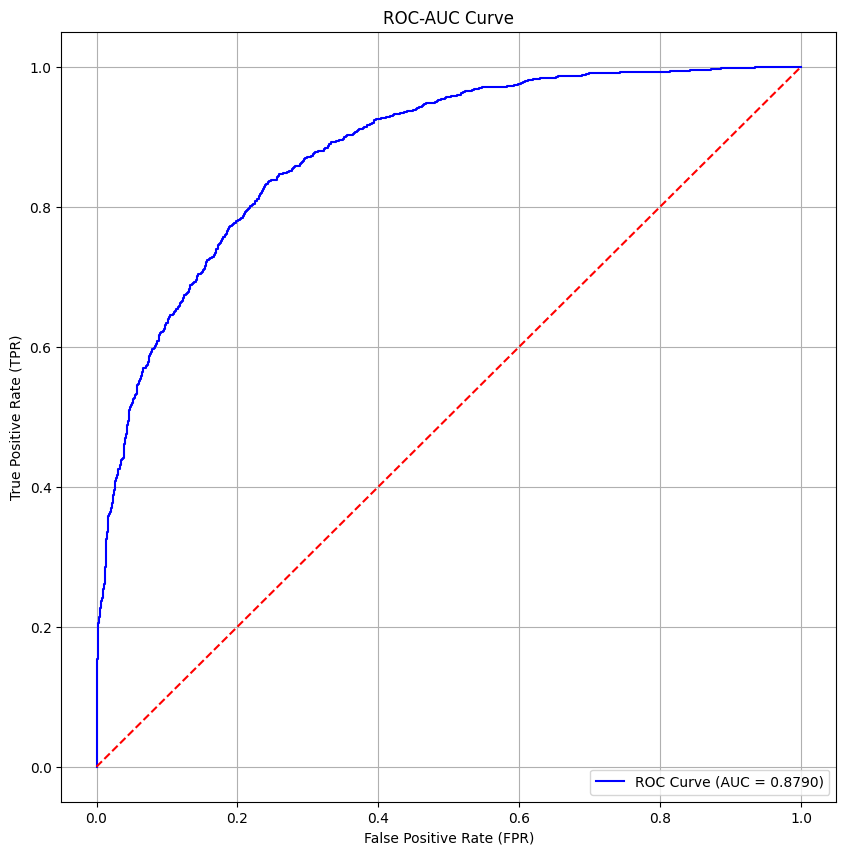

In [29]:
# # Evaluate the model and get results
results = evaluate_and_visualize_model(model, test_loader, device)

# Plot the confusion matrix
plot_confusion_matrix(results['conf_matrix'], class_names=['real', 'fake'])

# Plot the ROC-AUC curve
plot_roc_curve(results['test_labels'], results['test_probabilities'], results['roc_auc'])

### Combining val and test set and then testing model on a bigger test set

In [26]:
from torch.utils.data import ConcatDataset

# Combine val_dataset and test_dataset into a single larger dataset
combined_test_dataset = ConcatDataset([val_dataset, test_dataset])

# Create a DataLoader for the combined test dataset
combined_test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=True)

Testing the model: 100%|██████████| 93/93 [00:32<00:00,  2.90it/s]

Test Loss: 0.4893, Test Accuracy: 0.7873
Test Precision: 0.7773, Test Recall: 0.8055, Test F1-Score: 0.7911
Test ROC-AUC: 0.8767
Confusion Matrix:
[[1143  343]
 [ 289 1197]]


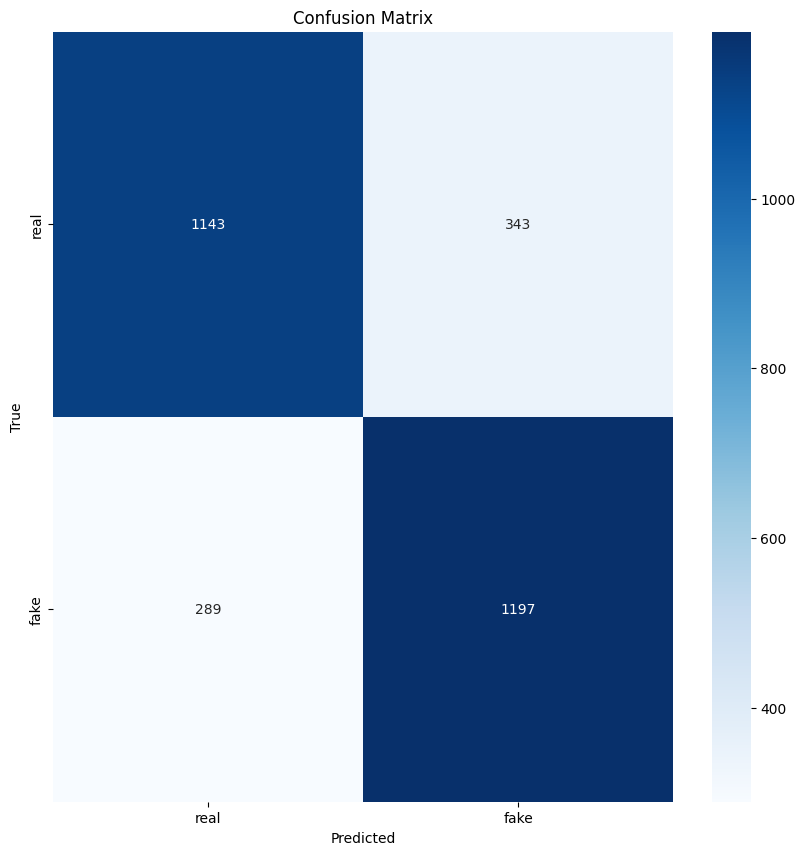

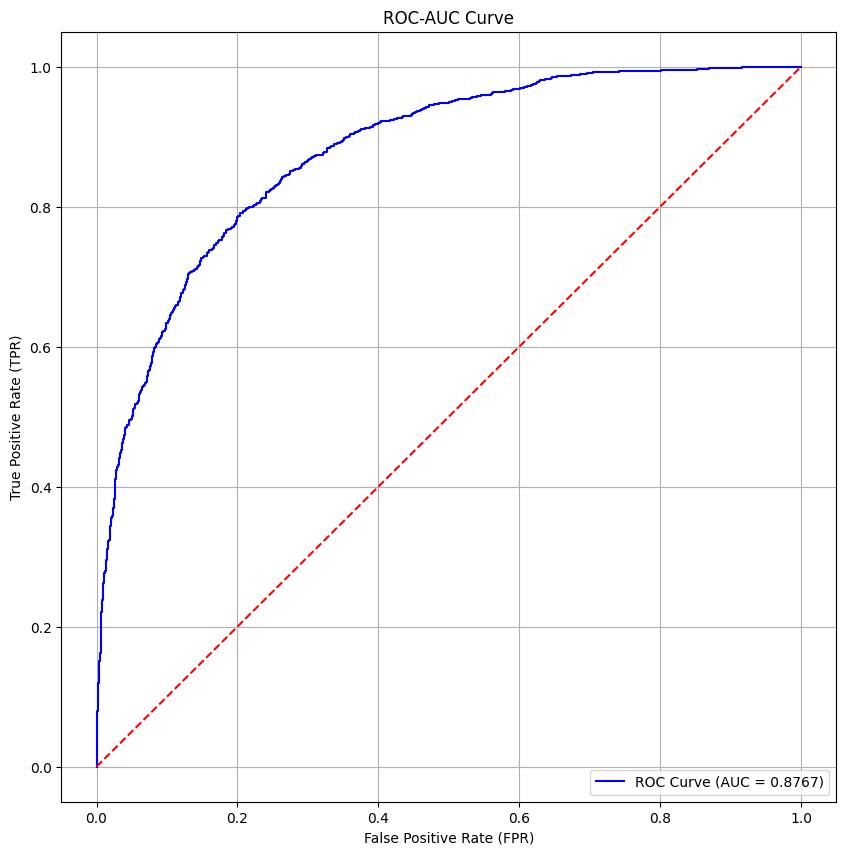

In [31]:
# Evaluate the model on the combined test set (validation + test)
results = evaluate_and_visualize_model(model, combined_test_loader, device)

# Plot the confusion matrix for the combined test set
plot_confusion_matrix(results['conf_matrix'], class_names=['real', 'fake'])

# Plot the ROC-AUC curve for the combined test set
plot_roc_curve(results['test_labels'], results['test_probabilities'], results['roc_auc'])